In [1]:
import glob

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import glob

In [2]:
data = pd.read_csv("../data/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")

In [3]:
data[data["study_id"] == 4003253]

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


## Per study:
### 1- Map coords for sagittal (x, y)
### 2- Map coords for axial (y, z)
### 3 Extrapolate the y for axial and z for sagittal from the slice metadata
### 4 Add a buffer 20 px from min and max for each, aggregated per joint

In [4]:
base_path = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
study = 4003253
series = 702807833  #T2STIR for canal stenosis
instance = 9
file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_slice = pydicom.dcmread(file)
data_slice

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.9
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.9
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223713.422388'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.8'
(0018, 5100) Patient Position                   

In [5]:
import torch


# !TODO: Move to util func
def show_mid_slices(img4d):
    if torch.is_tensor(img4d):
        try:
            img4d = img4d.detach().cpu().numpy()
        except Exception as e:
            pass

    for i in range(len(img4d)):
        img3d = img4d[i]
        img_shape = img3d.shape

        a1 = plt.subplot(3, 3, i * 3 + 1)
        a1.imshow(img3d[:, :, img_shape[2] // 2], cmap="hot")
        a1.grid(None)

        a2 = plt.subplot(3, 3, i * 3 + 2)
        a2.imshow(img3d[:, img_shape[1] // 2, :], cmap="hot")
        a2.grid(None)

        a3 = plt.subplot(3, 3, i * 3 + 3)
        a3.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="hot")
        a3.grid(None)

    plt.show()

In [6]:
data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

In [7]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

In [8]:
def get_sagittal_bounding_boxes(series_data):
    sagittal_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            sagittal_coords.append([row["level"], i, row["y"], row["x"]])

    sagittal_coords = pd.DataFrame(sagittal_coords, columns=("level", "x", "y", "z"))
    sagittal_coords_groups = sagittal_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    sagittal_coords_groups["x_s"] = sagittal_coords_groups[("x", "min")].values
    sagittal_coords_groups["x_e"] = sagittal_coords_groups[("x", "max")].values
    sagittal_coords_groups["y_s"] = sagittal_coords_groups[("y", "min")].values - 20
    sagittal_coords_groups["y_e"] = sagittal_coords_groups[("y", "max")].values + 20
    sagittal_coords_groups["z_s"] = sagittal_coords_groups[("z", "min")].values - 20
    sagittal_coords_groups["z_e"] = sagittal_coords_groups[("z", "max")].values + 20

    return sagittal_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]

In [9]:
get_sagittal_bounding_boxes(data_for_series)

,x_s,x_e,y_s,y_e,z_s,z_e
,,,,,,
level,,,,,,
L1/L2,8,8,207.964602,247.964602,302.831858,342.831858
L2/L3,8,8,275.714286,315.714286,300.571429,340.571429
L3/L4,8,8,351.818182,391.818182,303.030303,343.030303
L4/L5,8,8,407.327434,447.327434,315.292035,355.292035
L5/S1,8,8,463.964602,503.964602,333.415929,373.415929


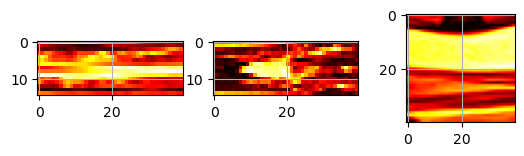

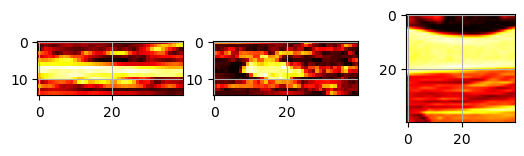

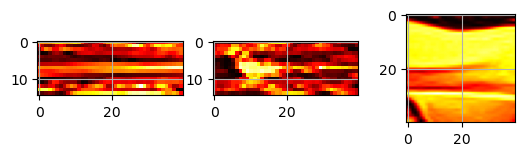

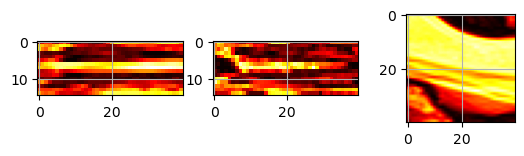

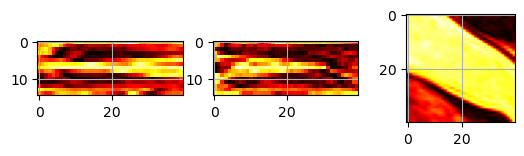

In [10]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[:, y_s:y_e, z_s:z_e], 0))

In [11]:
series = 1054713880  # T1 for foraminal narrowing
instance = 4

file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

# 5. Volume cube detection will be on low definition volumes
# 6. And the diagnosis inference will be based on the full res using the coordinates extracted previously

In [12]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

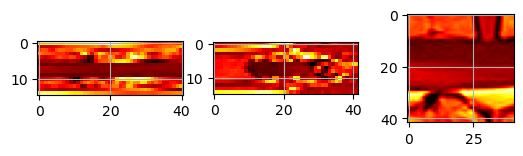

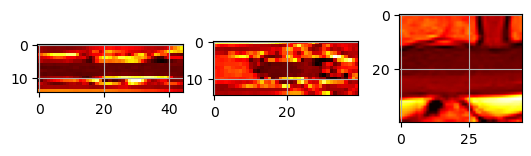

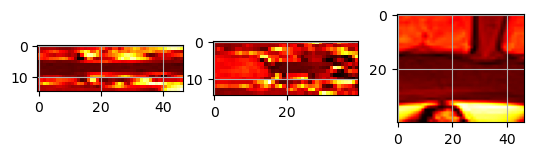

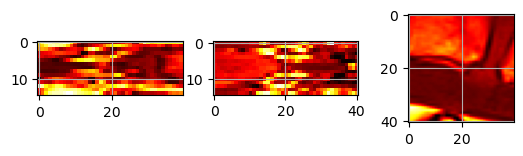

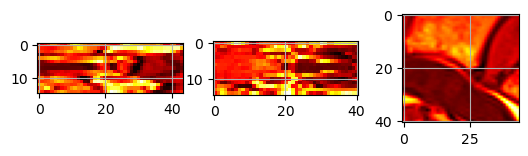

In [13]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[:, y_s:y_e, z_s:z_e], 0))

In [14]:
def get_sagittal_vol_masks(volume, series_data):
    ret = []

    bounding_boxes = get_sagittal_bounding_boxes(series_data)
    for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        mask = np.zeros(volume.shape)
        # Don't chop x for sagittal
        mask[:, y_s:y_e, z_s:z_e] = 1
        ret.append(mask)

    return ret

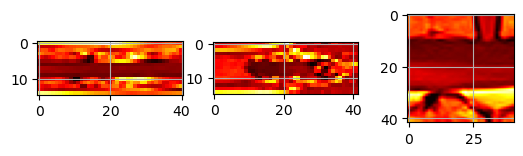

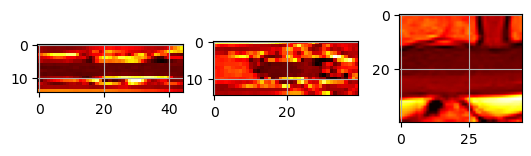

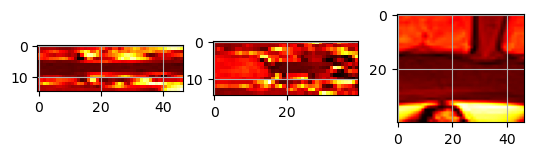

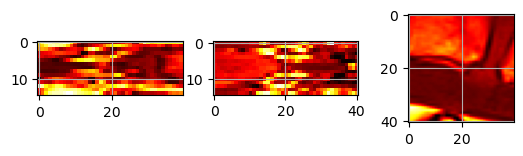

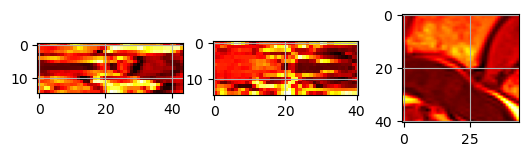

In [15]:
masks = get_sagittal_vol_masks(series_volume, data_for_series)
for mask in masks:
    masked = series_volume * mask

    coords = np.argwhere(masked)
    x_min, y_min, z_min = coords.min(axis=0)
    x_max, y_max, z_max = coords.max(axis=0)
    cropped = masked[x_min:x_max + 1, y_min:y_max + 1, z_min:z_max + 1]

    show_mid_slices(np.expand_dims(cropped, 0))

In [16]:
def get_sagittal_vol_segments(volume, series_data):
    segmentation = np.zeros(volume.shape)

    bounding_boxes = get_sagittal_bounding_boxes(series_data)
    for level_id, level in enumerate(["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]):
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        # Don't chop x for sagittal
        segmentation[:, y_s:y_e, z_s:z_e] = level_id + 1

    return segmentation

In [17]:
import torchio as tio

test_subject = tio.Subject(
    one_image=tio.ScalarImage(tensor=np.expand_dims(series_volume, 0)),
    a_segmentation=tio.LabelMap(tensor=np.expand_dims(get_sagittal_vol_segments(series_volume, data_for_series), 0)),
    study_id="test",
    series_id="es"
)

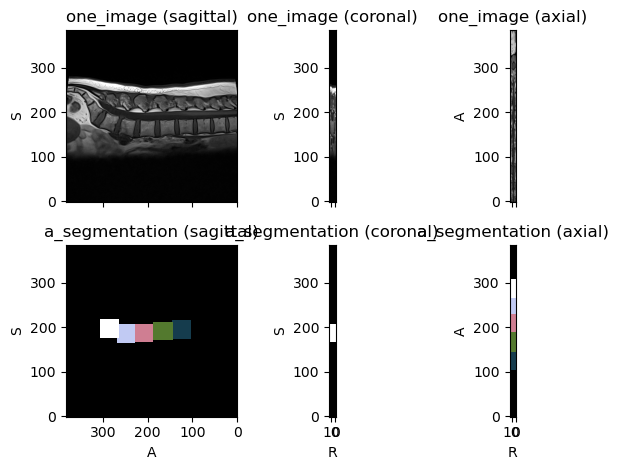

In [18]:
test_subject.plot()

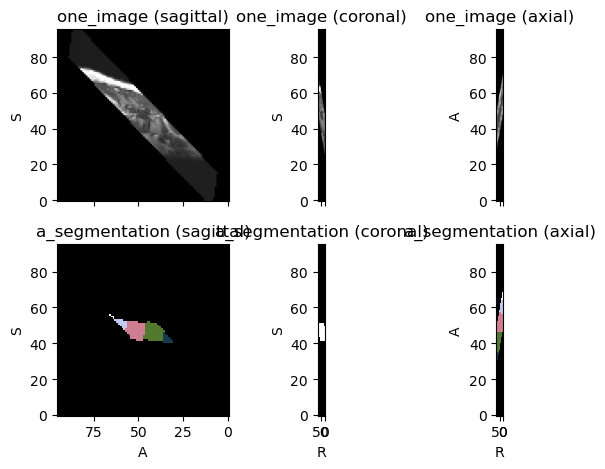

In [19]:
transform_3d = tio.Compose([
    tio.Resize((96, 96, 96), image_interpolation="bspline"),
    tio.RandomAffine(p=1),
])

transform_3d(test_subject).plot()

In [20]:
series = 2448190387

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]
series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

def get_axial_bounding_boxes(series_data):
    axial_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            axial_coords.append([row["level"], i, row["y"], row["x"]])

    axial_coords = pd.DataFrame(axial_coords, columns=("level", "x", "y", "z"))
    axial_coords_groups = axial_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    axial_coords_groups["x_s"] = axial_coords_groups[("x", "min")].values - 3
    axial_coords_groups["x_e"] = axial_coords_groups[("x", "max")].values + 3
    axial_coords_groups["y_s"] = axial_coords_groups[("y", "min")].values - 20
    axial_coords_groups["y_e"] = axial_coords_groups[("y", "max")].values + 20
    axial_coords_groups["z_s"] = axial_coords_groups[("z", "min")].values - 20
    axial_coords_groups["z_e"] = axial_coords_groups[("z", "max")].values + 20

    return axial_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]


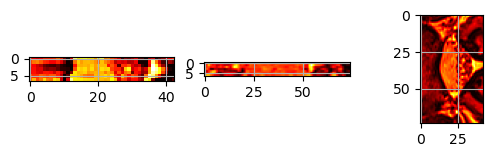

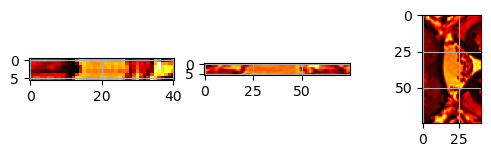

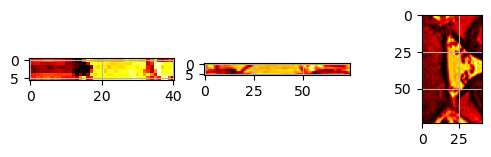

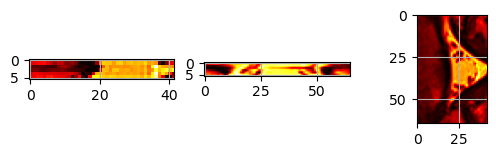

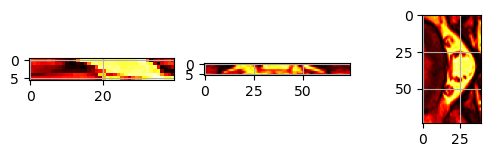

In [21]:
bounding_boxes = get_axial_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[x_s:x_e, y_s:y_e, z_s:z_e], 0))

In [22]:
def get_axial_vol_segments(volume, series_data):
    ret = []
    
    bounding_boxes = get_axial_bounding_boxes(series_data)
    for level_id, level in enumerate(["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]):
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)
        
        segmentation = np.zeros(volume.shape)
        segmentation[x_s:x_e, y_s:y_e, z_s:z_e] = 1
        ret.append(segmentation)
        
    return np.array(ret)


In [23]:
test_subject_2 = tio.Subject(
    one_image=tio.ScalarImage(tensor=np.expand_dims(series_volume, 0)),
    a_segmentation=tio.LabelMap(tensor=get_axial_vol_segments(series_volume, data_for_series)),
    study_id="test2",
    series_id="es2"
)

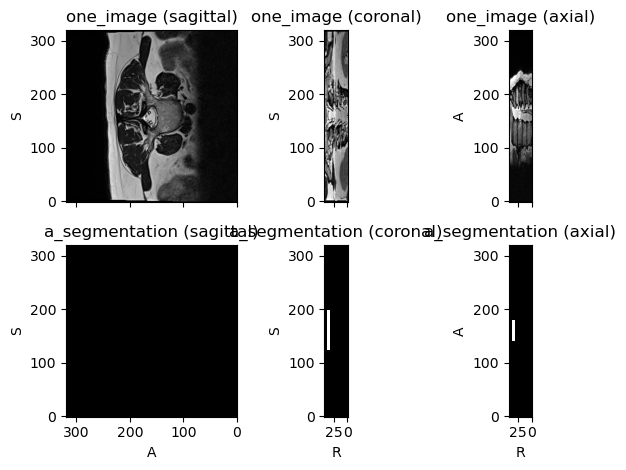

In [24]:
test_subject_2.plot()

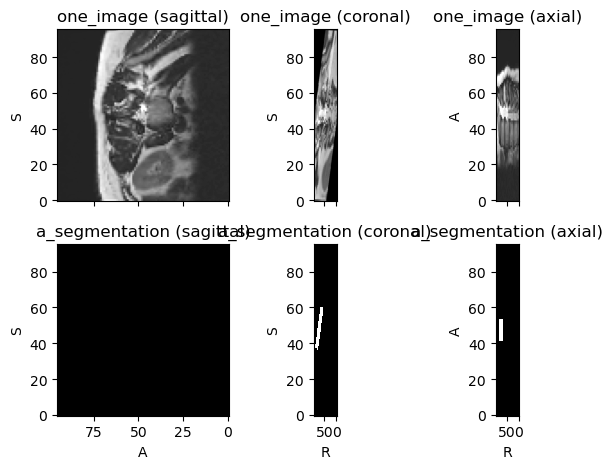

In [25]:
transform_3d(test_subject_2).plot()

In [26]:
test_subject_2.get_images()[0].tensor

tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  5,  4,  ..., 14, 11,  6],
          [ 0, 13,  9,  ..., 15, 16,  4],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0, 10, 12,  ..., 12, 16,  5],
          [ 0, 14, 19,  ..., 16, 14,  6],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0, 13,  8,  ..., 10, 10,  3],
          [ 0,  9,  7,  ...,  9, 11,  3],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         ...,

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0, 15, 19,  ...,  8,  7,  5],
          [ 0, 12, 17,  ...,  9,  4,  5],
          ...,
          [ 0,  0,  0,  ...,  0,  0, 

In [27]:
from train_segmentation_model import UNet

model = UNet(n_channels=1, n_classes=5)

inp = transform_3d(test_subject_2)
out = model(inp.get_images()[0].tensor.unsqueeze(0))

FileNotFoundError: [Errno 2] No such file or directory: './data/rsna-2024-lumbar-spine-degenerative-classification/train.csv'

In [ ]:
#https://github.com/milesial/Pytorch-UNet/blob/master/train.py

In [ ]:
out.shape, inp["a_segmentation"].tensor.shape

In [ ]:
nn.CrossEntropyLoss()(out, inp["a_segmentation"].tensor.unsqueeze(0))

In [ ]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=False)

In [ ]:
dice_loss(out, inp["a_segmentation"].tensor.unsqueeze(0), multiclass=True)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()(out, inp["a_segmentation"].tensor.unsqueeze(0)) +  dice_loss(out, inp["a_segmentation"].tensor.unsqueeze(0), multiclass=True)
loss.backward()
opt.step()
opt.zero_grad(set_to_none=True)

In [ ]:
out = model(inp.get_images()[0].tensor.unsqueeze(0))

In [ ]:
nn.CrossEntropyLoss()(out, inp["a_segmentation"].tensor.unsqueeze(0))

In [ ]:
dice_loss(out, inp["a_segmentation"].tensor.unsqueeze(0), multiclass=True)